# GooLeNet

**首个过100个层的网络**

## Inception

*V1*:

- input:
- Parallel:(Inception 1)
    - Parallel 1: 64@1x1 Conv
    - Parallel 2: 96@1x1 Conv >> 128@3x3 Conv Pad 1
    - Parallel 3: 16@1x1 Conv >> 32@5x5 Conv Pad 2
    - Parallel 4: 32@3x3 MaxPool Pad 1 >> 32@1x1 Conv
- output: Concatenation

> 通过Inception比单纯的3x3和5x5的卷积层，有更少的参数个数和计算复杂度

## 结构：

- Stage 1&2:
    - 3x224x224
        - 64@7x7 Conv stride 2 pad 3
        - 64@3x3 MaxPool stride 2 pad 1
        - 64@1x1 Conv
        - 192@3x3 Conv pad 1
        - 192@3x3 MaxPool stride 2 pad 1
    - 192x28x28
- Stage 3:
    - 192x28x28
        - Inception
            - 64@1x1 Conv
            - 96@1x1 Conv >> 128@3x3 Conv Pad 1
            - 16@1x1 Conv >> 32@5x5 Conv Pad 2
            - 32@3x3 MaxPool >> 32@1x1 Conv 
    - 256@28x28
        - Inception
            - 1281 Conv
            - 128@1x1 Conv >> 196@3x3 Conv Pad 1
            - 32@1x1 Conv >> 96@5x5 Conv Pad 2
            - 64@3x3 MaxPool >> 64@1x1 Conv
    - 480x28x28
        - 480@3x3 MaxPool stride 2 pad 1?
    - 480x14x14
- Stage 4:
    - 480x14x14
        - Inception 512x14x14
        - Inception 512x14x14
        - Inception 512x14x14
        - Inception 512x14x14
        - Inception 832x14x14
        - 832@3x3 MaxPool stride 2 pad 1?
    - 832x7x7
- Stage 5:
    - 832x7x7
        - Inception 832x7x7
        - Inception 1024x7x7
        - GlobalAvgPool
    - 1024x1x1

## 总结：

- 每一个 Inception 块有4调不同的超参数的卷积层
- 优点：模型参数少，计算复杂度低
- 使用了9个Inception，第一个上百层的网络

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
import os
import time
from matplotlib import pyplot as plt
from matplotlib_inline import backend_inline
%matplotlib inline
backend_inline.set_matplotlib_formats('svg')

In [2]:
""" Inception """
class Inception(nn.Module):
    def __init__(self, in_channels, c1, c2, c3, c4):
        super().__init__()
        self.p1_1 = nn.Conv2d(in_channels=in_channels, out_channels=c1, kernel_size=1)
        self.p2_1 = nn.Conv2d(in_channels=in_channels, out_channels=c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(in_channels=c2[0], out_channels=c2[1], kernel_size=3, padding=1)
        self.p3_1 = nn.Conv2d(in_channels=in_channels, out_channels=c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(in_channels=c3[0], out_channels=c3[1], kernel_size=5, padding=2)
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels=in_channels, out_channels=c4, kernel_size=1)
        
    def forward(self, X):
        p1 = F.relu(self.p1_1(X))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(X))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(X))))
        p4 = F.relu(self.p4_2(self.p4_1(X)))
        return torch.cat([p1, p2, p3, p4], dim=1) # 0是批量 1是通道

In [3]:
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

b2 = nn.Sequential(
    nn.Conv2d(64, 64, kernel_size=1), nn.ReLU(),
    nn.Conv2d(64, 192, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

b3 = nn.Sequential(
    Inception(192, 64, (96, 128), (16, 32), 32),
    Inception(256, 128, (128, 192), (32, 96), 64),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

b4 = nn.Sequential(
    Inception(480, 192, (96, 208), (16, 48), 64),
    Inception(512, 160, (112, 224), (24, 64), 64),
    Inception(512, 128, (128, 256), (24, 64), 64),
    Inception(512, 112, (144, 288), (32, 64), 64),
    Inception(528, 256, (160, 320), (32, 128), 128),   
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

b5 = nn.Sequential(
    Inception(832, 256, (160, 320), (32, 128), 128),
    Inception(832, 384, (192, 384), (48, 128), 128),
    nn.AdaptiveAvgPool2d((1,1)),
    nn.Flatten()
)

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

In [4]:
X = torch.rand(size=(1, 1, 224, 224), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(f"{layer.__class__.__name__} : {X.shape}")

Sequential : torch.Size([1, 64, 56, 56])
Sequential : torch.Size([1, 192, 28, 28])
Sequential : torch.Size([1, 480, 14, 14])
Sequential : torch.Size([1, 832, 7, 7])
Sequential : torch.Size([1, 1024])
Linear : torch.Size([1, 10])


/usr/local/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [5]:
resize = 224
batch_size=256
num_cpu_cores = os.cpu_count()
trans = [torchvision.transforms.ToTensor()]
if resize is not None:
    trans.insert(0, torchvision.transforms.Resize(resize))
trans = torchvision.transforms.Compose(trans)
train_iter = torch.utils.data.DataLoader(torchvision.datasets.FashionMNIST(root="./data", train=True, download=True, transform=trans), batch_size, shuffle=True, num_workers=num_cpu_cores)
test_iter = torch.utils.data.DataLoader(torchvision.datasets.FashionMNIST(root="./data", train=False, download=True, transform=trans), batch_size, shuffle=True, num_workers=num_cpu_cores)

/usr/local/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
""" 累加器对象 """
class Accumulator: # 累加器对象
    """ 在 n 个变量上累加 """
    def __init__(self, n):
        self.data = [0.0] * n # python 语法 [0]*n将n个list连接在一起

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
        # zip() 将迭代器打包成元组

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, index):
        return self.data[index]

""" 与真实值对比 """
def accuracy(y_hat, y):
    """ 分类问题，统计正确个数 """
    # y_hat 是二维矩阵，取每一行的最大值
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1) # 返回最大值对应的序号
    cmp = y_hat.type(y.dtype) == y   # 保证 y 和 y_hat 类型相同
    # cmp 是 bool 类型
    return float(cmp.type(y.dtype).sum())

def evaluate_accuracy_gpu(net, data_iter):
    """使用GPU计算模型在数据集上的精度"""
    device = try_gpu() 
    if isinstance(net, torch.nn.Module):
        net.eval()
    metric = Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

def try_gpu(i = 0):
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f"cuda:{i}")
    else:
        return torch.device('cpu')
    

def train_gpu(net, train_iter, test_iter, num_epochs, lr):
    device = try_gpu()
    print(f'training on {device}')

    def init_weight(m):
        if type(m) == torch.nn.Linear or type(m) == torch.nn.Conv2d:
            torch.nn.init.xavier_uniform_(m.weight)
    net.apply(init_weight)

    net.to(device)
    optimizer = torch.optim.SGD(params=net.parameters(), lr=lr)
    loss = torch.nn.CrossEntropyLoss()
    
    train_l, train_acc, test_acc, time_l = [], [], [], []

    for epoch in range(num_epochs):
        metric = Accumulator(3)
        net.train()
        start = time.perf_counter()
        for i, (X, y) in enumerate(train_iter):
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], accuracy(y_hat=y_hat, y=y), X.shape[0])
        end = time.perf_counter()
        train_l.append(metric[0] / metric[2])
        train_acc.append(metric[1] / metric[2])
        test_acc.append(evaluate_accuracy_gpu(net, test_iter))
        time_l.append(end-start)
        print(f"Epoch {epoch+1}, Using Time : {time_l[-1]:.3f}, train_acc : {train_acc[-1]:.4f} test_acc : {test_acc[-1]:.4f}")
    """绘图"""
    backend_inline.set_matplotlib_formats("svg")
    plt.rcParams['figure.figsize']=(7, 5)
    plt.plot(list(range(num_epochs)), train_l, 'm--')
    plt.plot(list(range(num_epochs)), train_acc, 'r:')
    plt.plot(list(range(num_epochs)), test_acc, 'g-')

    plt.legend(["train_loss", "train_accuracy", "test_accuracy"])
    plt.xlabel('epochs')
    plt.ylabel('percent')
    plt.title(f'{num_epochs} epochs')
    plt.grid(True)

    print(f"Test accuracy : {test_acc[-1]:.3f}")
    print(f'{metric[2] * num_epochs / sum(time_l):.1f} examples/sec on {str(torch.cuda.get_device_name())}')

training on cuda:0
Epoch 1, Using Time : 171.886, train_acc : 0.1321 test_acc : 0.2079
Epoch 2, Using Time : 172.082, train_acc : 0.2697 test_acc : 0.4409
Epoch 3, Using Time : 172.395, train_acc : 0.5606 test_acc : 0.6468
Epoch 4, Using Time : 172.624, train_acc : 0.6759 test_acc : 0.7215
Epoch 5, Using Time : 172.646, train_acc : 0.7592 test_acc : 0.7781
Epoch 6, Using Time : 172.971, train_acc : 0.8149 test_acc : 0.8309
Epoch 7, Using Time : 172.964, train_acc : 0.8408 test_acc : 0.8059
Epoch 8, Using Time : 172.977, train_acc : 0.8561 test_acc : 0.8112
Epoch 9, Using Time : 172.653, train_acc : 0.7934 test_acc : 0.8071
Epoch 10, Using Time : 172.957, train_acc : 0.8703 test_acc : 0.8549
Epoch 11, Using Time : 172.857, train_acc : 0.8803 test_acc : 0.8408
Epoch 12, Using Time : 172.926, train_acc : 0.8873 test_acc : 0.8626
Epoch 13, Using Time : 173.013, train_acc : 0.8950 test_acc : 0.8658
Epoch 14, Using Time : 173.091, train_acc : 0.8977 test_acc : 0.8209
Epoch 15, Using Time : 1

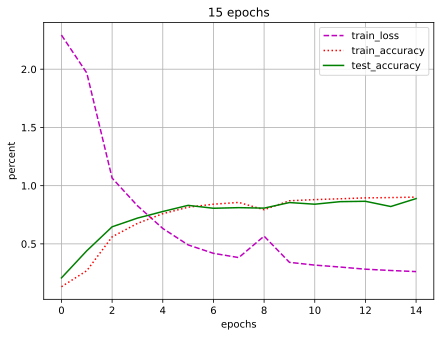

In [7]:
lr, num_epochs = 0.1, 15
start = time.perf_counter()
train_gpu(net, train_iter, test_iter, num_epochs, lr)
end = time.perf_counter()
print(f"Total Time : {end-start:3f}")

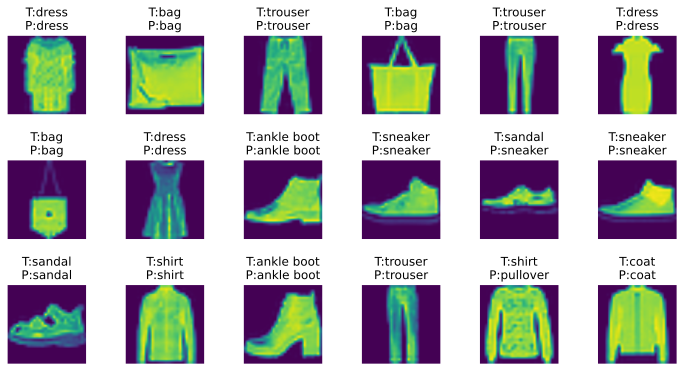

In [8]:
""" 获得标签索引对应文本"""
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', \
                 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

""" 打印图片 """
def show_img(imgs, num_rows, num_cols, title=None, scale=1.5):
    figsize = (num_cols * scale, num_rows * scale)
    plt.rcParams["figure.figsize"] = figsize
    for i in range(num_rows * num_cols):
        plt.subplot(num_rows, num_cols, i+1)
        plt.title(title[i])
        plt.axis('off')
        if torch.is_tensor(imgs[i].numpy()):
            plt.imshow(imgs[i].numpy())
        else:
            plt.imshow(imgs[i])

def predtic_ch3(net, test_iter, rows, cols):
    n = rows * cols
    for X, y in test_iter:
        break
    X = X.to(try_gpu())
    trues = get_fashion_mnist_labels(y)
    predicts = get_fashion_mnist_labels(net(X).argmax(axis=1))
    title = [f"T:{true}\nP:{predict}" for true, predict in zip(trues, predicts)]
    X = X.to(torch.device('cpu'))
    show_img(X[0:n].reshape([n, 224, 224]), rows, cols, title=title[0:n], scale=2)
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    
predtic_ch3(net, test_iter, 3, 6)

In [10]:
torch.cuda.empty_cache()

# QA

- 1x1 的卷积层，降通道数，减少计算量
- $2^n$ 利于并行
- 优先使用经典网络，不行的话优先调整通道数
- V3,将3x3转换成1x3和3x1的优点是减少计算量